In [41]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
import numpy as np

In [42]:
ten_k_df = pd.read_csv(r"X:\genie_link\LabData\Data\metabolomics\sample_with_meta.csv")
metabolomics_df = pd.read_csv(r"X:\genie_link\LabData\Analyses\davidkro\batch_normalizations\inter_batch_normalized\normalized_compounds_batches_1_16_log_.csv")

# Process healthy controls 

In [43]:
metabolomics_lvs = pd.DataFrame(metabolomics_df.T.index, columns=['name_dna'])
healthy_controls = pd.merge(ten_k_df, metabolomics_lvs, on='name_dna', how='inner')
healthy_controls = healthy_controls[healthy_controls['research_stage'] == 'baseline']
healthy_controls.dropna(subset=['RegistrationCode', 'research_stage', 'age', 'gender', 'bmi'], inplace=True)
healthy_controls.drop(['primary_tube_id_dna', 'participant_id', 'yob', 'research_stage'], axis=1, inplace=True)
healthy_controls = healthy_controls.rename(columns={'name_dna': 'lv_code'})
healthy_controls = healthy_controls.astype({'age': 'int64'}, copy=False)

# Process PDAC Patients

In [44]:
pdac_meta = pd.read_excel(r"X:\genie_link\LabData\Data\StudySpecificData\pancreas\first_round_meta.xlsx", sheet_name='user_metadata')  
pdac_meta.columns = pdac_meta.columns.str.strip()
columns_to_keep = ['SPC_ID', 'Gender', 'Age', 'BMI'] 
pdac_meta = pdac_meta[columns_to_keep]

In [45]:
# plate1 = pd.read_excel(r'X:\genie_link\LabData\Analyses\barakdan\PDAC\Serum samples 27Jun2024_Final.xlsx', sheet_name='Pancreatic_Plate1')
# plate2 = pd.read_excel(r'X:\genie_link\LabData\Analyses\barakdan\PDAC\Serum samples 27Jun2024_Final.xlsx', sheet_name='Pancreatic_Plate2')
# plate3 = pd.read_excel(r'X:\genie_link\LabData\Analyses\barakdan\PDAC\Serum samples 27Jun2024_Final.xlsx', sheet_name='Pancreatic_Plate3')
# plate4 = pd.read_excel(r'X:\genie_link\LabData\Analyses\barakdan\PDAC\Serum samples 27Jun2024_Final.xlsx', sheet_name='Pancreatic_Plate4')

In [46]:
# Integrating sample plate metadata for PDAC patients.

file_path = r'X:\genie_link\LabData\Analyses\barakdan\PDAC\Serum samples 27Jun2024_Final.xlsx'

# Define sheet names and barcode columns
sheet_names = ['Pancreatic_Plate1', 'Pancreatic_Plate2', 'Pancreatic_Plate3', 'Pancreatic_Plate4']
barcode_columns = ['LV Barcodes Plate1_1', 'LV Barcodes Plate2_1', 'LV Barcodes Plate3_1', 'LV Barcodes Plate4_1']

plates = []
for sheet, barcode_col in zip(sheet_names, barcode_columns):
    plate = pd.read_excel(file_path, sheet_name=sheet)
    plate.columns = plate.columns.str.replace('\n', '', regex=True) 
    plate = plate[['SPC_ID', barcode_col, 'Date of sample aqcuisition']].rename(columns={barcode_col: 'lv_code'})
    plates.append(plate)

plates_df = pd.concat(plates, axis=0, ignore_index=True)

pdac_samples = pd.merge(pdac_meta, plates_df, on='SPC_ID', how='left')

pdac_samples.dropna(inplace=True)
pdac_samples.sort_values(by=['SPC_ID', 'Date of sample aqcuisition'], inplace=True)
pdac_samples.drop_duplicates(subset='SPC_ID', keep='first', inplace=True)
pdac_samples.rename(columns={'Gender': 'gender', 'Age': 'age', 'BMI': 'bmi'}, inplace=True)
pdac_samples['gender'].replace({'F': 0.0, 'M': 1.0}, inplace=True)

# Matching helthy controls to pdac patients

In [47]:
healthy_controls['PDAC sample'] = 0  
pdac_samples['PDAC sample'] = 1  

# Features for matching (covariates: age, gender, bmi)
features = ['age', 'gender', 'bmi']

# Standardizing the features
scaler = StandardScaler()
pdac_features_scaled = scaler.fit_transform(pdac_samples[features])
healthy_features_scaled = scaler.transform(healthy_controls[features])

# Matching 1:50
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(healthy_features_scaled)

distances, indices = nbrs.kneighbors(pdac_features_scaled)

matched_results = []
for patient_idx, match_indices in enumerate(indices):
    pdac_patient = pdac_samples.iloc[patient_idx]
    
    matched_patients = healthy_controls.iloc[match_indices].copy()
    
    for _, healthy_control in matched_patients.iterrows():
        matched_results.append({
            'PDAC ID': pdac_patient['SPC_ID'],  
            'PDAC Age': pdac_patient['age'],  
            'PDAC Gender': pdac_patient['gender'],  
            'PDAC BMI': pdac_patient['bmi'],  
            'PDAC LV Code': pdac_patient['lv_code'],  
            'Matched Healthy Control': healthy_control['RegistrationCode'],  
            'Healthy Control LV Code': healthy_control['lv_code'],  
            'Healthy Age': healthy_control['age'],  
            'Healthy Gender': healthy_control['gender'], 
            'Healthy BMI': healthy_control['bmi'],  
        })

matched_df = pd.DataFrame(matched_results)

# The individual-level metabolic signature of PDAC

In [48]:
matching_results = matched_df.copy()
matching_results.drop(['PDAC Age', 'PDAC Gender', 'PDAC BMI', 'Healthy Age', 'Healthy Gender', 'Healthy BMI'], axis=1, inplace=True)

healthy_control_lv_codes = matched_df['Healthy Control LV Code']
healthy_metabolites = metabolomics_df[['Compound'] + healthy_control_lv_codes.tolist()]

pdac_lv_codes = matched_df['PDAC LV Code']
pdac_metabolites = metabolomics_df[['Compound'] + pdac_lv_codes.tolist()]
pdac_metabolites = pdac_metabolites.fillna(0)

In [49]:
# calculate the mean and std of metabolite values for each PDAC patient based on their matched healthy controls.

control_means = {}
control_stds = {}

for pdac_id in matched_df['PDAC ID']:  
    
    healthy_lvs = matched_df[matched_df['PDAC ID'] == pdac_id]['Healthy Control LV Code']
    healthy_data = metabolomics_df[['Compound'] + healthy_lvs.tolist()]

    control_means[pdac_id] = healthy_data.iloc[:, 1:].mean(axis=1)
    control_stds[pdac_id] = healthy_data.iloc[:, 1:].std(axis=1)

In [50]:
# Calculate z-scores for PDAC patients

z_scores = {}

for idx, row in matched_df.iterrows():
    pdac_id = row['PDAC ID']
    pdac_lv_code = row['PDAC LV Code']
    
    pdac_data = metabolomics_df[['Compound', pdac_lv_code]]
    
    # Calculating z-scores for each metabolite as the deviation from the healthy control mean, standardized by the standard deviation.
    z_scores[pdac_id] = (pdac_data.iloc[:, 1] - control_means[pdac_id]) / control_stds[pdac_id]

z_scores_df = pd.DataFrame(z_scores)

# Replace inf values with row-wise max (excluding inf).
if 'SPC_514' in z_scores_df.columns:
    inf_mask = np.isinf(z_scores_df['SPC_514']) 
    row_max_values = z_scores_df.iloc[:, 1:].replace([np.inf, -np.inf], np.nan).max(axis=1)  
    z_scores_df.loc[inf_mask, 'SPC_514'] = row_max_values[inf_mask]  

z_scores_df.insert(0, 'Compound', pdac_data['Compound'])
z_scores_df.fillna(0, inplace=True)
z_scores_df

,Compound,SPC_128,SPC_203,SPC_280,SPC_397,SPC_425,SPC_430,SPC_431,SPC_481,SPC_494,SPC_514,SPC_540,SPC_573,SPC_650,SPC_667,SPC_674
0,3.99_355.2483m/z,-0.001328,-1.246189,0.364567,4.564625,-0.241960,-0.297077,-1.230370,-0.668980,-0.367089,-1.099405,0.032227,-0.364272,0.058359,-0.934652,-1.012808
1,3.99_357.1006m/z,0.552092,-1.346033,-0.027138,0.733271,-1.341148,0.011776,-1.116715,-0.668933,-0.148516,0.304060,0.356969,-1.821933,-1.761953,-0.685663,-1.758719
2,3.99_479.2644m/z,-1.201124,-0.257631,0.339366,-0.016204,-0.165272,0.335430,-1.595186,0.653462,-0.027027,-0.994897,1.511848,-0.466099,-1.427046,1.320402,-0.436509
3,3.99_491.2279m/z,-0.143507,-1.073224,0.203948,-1.552552,-0.778448,-1.365793,-0.583360,-0.244568,0.307069,-1.477921,0.139552,-0.812123,-0.591129,-1.542122,-0.194963
4,3.99_495.2595m/z,-0.973142,-0.436215,0.364762,1.521933,-0.637361,0.417457,-0.991390,0.540761,-1.026823,-0.981178,1.120817,-1.820260,-0.722711,0.912163,-0.807792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,2.74_231.0336m/z,-1.732515,0.655601,-1.215009,-0.178818,1.158194,2.040643,-1.114805,1.423167,0.692425,2.019449,0.026171,1.004120,-1.058255,0.705139,1.289419
2459,2.74_280.9893m/z,0.941908,3.964302,2.989502,0.403566,-0.007400,-0.926992,0.126509,-0.626304,-0.221163,-0.987337,-1.027090,-0.312262,0.089865,0.889346,-0.036553
2460,2.74_511.2540m/z,0.171495,0.594778,0.966716,1.705837,-0.294617,-0.237865,0.351757,0.021019,1.499676,1.895157,1.473827,-0.513275,-1.083746,-0.491245,-1.089034
2461,2.74_583.3121m/z,0.736656,2.406347,2.640946,1.626265,-0.409129,3.637294,0.709054,0.381006,1.047327,-0.206635,1.995863,-0.540173,2.704657,1.060626,0.709906


# MannWhitney U test for significant metabolites

In [51]:
healthy_metabolites_full_lvs = healthy_controls['lv_code'].tolist()
healthy_metabolites_full = metabolomics_df[['Compound'] + healthy_metabolites_full_lvs]

pdac_metabolites_full_lvs = plates_df.dropna(subset=['lv_code'])['lv_code']
pdac_metabolites_full_lvs = [lv for lv in pdac_metabolites_full_lvs if lv != 'EMPTY']
pdac_metabolites_full = metabolomics_df[['Compound'] + pdac_metabolites_full_lvs]

In [52]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

results = []

# Define effect size categorization function for Cliff's Delta
def categorize_effect_size(value, thresholds):
    if abs(value) < thresholds[0]:
        return "Small"
    elif abs(value) < thresholds[1]:
        return "Medium"
    else:
        return "Large"

effect_size_threshold = {
    "Cliff's Delta": (0.147, 0.33)  
}

for metabolite in pdac_metabolites_full['Compound']:
    
    pdac_values = pdac_metabolites_full[pdac_metabolites_full['Compound'] == metabolite].iloc[:, 1:].values.flatten()
    healthy_values = healthy_metabolites_full[healthy_metabolites_full['Compound'] == metabolite].iloc[:, 1:].values.flatten()
    
    # Performing Mann-Whitney U test to compare PDAC and healthy groups.
    u_statistic, p_value = mannwhitneyu(pdac_values, healthy_values, alternative='two-sided')
    
    pdac_depleted = pdac_values.mean() - healthy_values.mean() < 0 # The metabolite is PDAC-depleted

    # Computing Cliff's Delta
    n1, n2 = len(pdac_values), len(healthy_values)
    effect_size_cliffs_delta = (np.sum(pdac_values[:, None] > healthy_values) - np.sum(pdac_values[:, None] < healthy_values)) / (n1 * n2)

    effect_category_cliffs_delta = categorize_effect_size(effect_size_cliffs_delta, effect_size_threshold["Cliff's Delta"])

    results.append({
        'Compound': metabolite,
        'U-statistic': u_statistic,
        'P-value': p_value,
        'PDAC_Mean': pdac_values.mean(),
        'Healthy_Mean': healthy_values.mean(),
        'Mean_Difference': pdac_values.mean() - healthy_values.mean(),
        'PDAC Depleted': pdac_depleted,
        'Effect Size Cliff’s Delta': effect_size_cliffs_delta,
        'Effect Category Cliff’s Delta': effect_category_cliffs_delta
    })

metabolites_directions = pd.DataFrame(results)

metabolites_directions['FDR-corrected P-value'] = multipletests(metabolites_directions['P-value'], method='fdr_bh')[1]

# Filtering by significance level (FDR < 0.05)
significant_metabolites = metabolites_directions[metabolites_directions['FDR-corrected P-value'] < 0.05]

print(significant_metabolites['Effect Category Cliff’s Delta'].value_counts())

# Further filtering to keep only Medium & Large effect size categories.
filtered_metabolites = significant_metabolites[significant_metabolites['Effect Category Cliff’s Delta'].isin(["Medium", "Large"])]

metabolites_directions = filtered_metabolites

print(metabolites_directions.head())

metabolites_directions = metabolites_directions.drop(columns=['Effect Size Cliff’s Delta', 'Effect Category Cliff’s Delta'])

Effect Category Cliff’s Delta
Medium    869
Large     692
Small     453
Name: count, dtype: int64
           Compound  U-statistic       P-value  PDAC_Mean  Healthy_Mean  \
0  3.99_355.2483m/z     179492.0  1.244678e-33   0.741337      0.975123   
1  3.99_357.1006m/z     205793.0  4.205477e-22   0.556793      0.793749   
3  3.99_491.2279m/z     236607.5  8.431329e-12   0.501898      0.713992   
6  3.99_257.2506m/z     222735.0  5.202850e-16   1.233087      1.488484   
7  3.99_505.3349m/z     232171.0  4.545884e-13   1.180563      1.355532   

   Mean_Difference  PDAC Depleted  Effect Size Cliff’s Delta  \
0        -0.233786           True                  -0.422518   
1        -0.236956           True                  -0.337900   
3        -0.212094           True                  -0.238760   
6        -0.255397           True                  -0.283392   
7        -0.174969           True                  -0.253034   

  Effect Category Cliff’s Delta  FDR-corrected P-value  
0        

In [53]:
# Merging with Z-scores

merged_z_scores_df = pd.merge(z_scores_df, metabolites_directions, on='Compound', how='inner')
merged_z_scores_df = merged_z_scores_df.drop(['U-statistic', 'P-value', 'PDAC_Mean', 'Healthy_Mean', 'Mean_Difference'], axis=1)

In [54]:
# Focus only on relevant directional changes (otherwise replace the value with 0).
def modify_row(row):
    numeric_cols = row.index.difference(['Compound', 'PDAC Depleted']) 

    # Set positive values to 0 for PDAC-depleted metabolites, and negative values to 0 otherwise.
    if row['PDAC Depleted']:  
        row[numeric_cols] = row[numeric_cols].apply(lambda x: 0 if x > 0 else x)
    else:  
        row[numeric_cols] = row[numeric_cols].apply(lambda x: 0 if x < 0 else x)
    return row

merged_z_scores_df = merged_z_scores_df.apply(modify_row, axis=1)
merged_z_scores_df

,Compound,SPC_128,SPC_203,SPC_280,SPC_397,SPC_425,SPC_430,SPC_431,SPC_481,SPC_494,SPC_514,SPC_540,SPC_573,SPC_650,SPC_667,SPC_674,PDAC Depleted,FDR-corrected P-value
0,3.99_355.2483m/z,-0.001328,-1.246189,0.000000,0.000000,-0.241960,-0.297077,-1.230370,-0.668980,-0.367089,-1.099405,0.000000,-0.364272,0.000000,-0.934652,-1.012808,True,0.000000e+00
1,3.99_357.1006m/z,0.000000,-1.346033,-0.027138,0.000000,-1.341148,0.000000,-1.116715,-0.668933,-0.148516,0.000000,0.000000,-1.821933,-1.761953,-0.685663,-1.758719,True,0.000000e+00
2,3.99_491.2279m/z,-0.143507,-1.073224,0.000000,-1.552552,-0.778448,-1.365793,-0.583360,-0.244568,0.000000,-1.477921,0.000000,-0.812123,-0.591129,-1.542122,-0.194963,True,0.000000e+00
3,3.99_257.2506m/z,0.000000,-1.241238,0.000000,0.000000,-0.413096,0.000000,-1.052785,-0.089443,0.000000,0.000000,0.000000,-2.246001,-0.658519,-0.766236,-1.874552,True,0.000000e+00
4,3.99_505.3349m/z,-1.793131,-1.481150,-1.228842,-0.376818,-2.309916,-1.505751,-2.046117,-0.447056,-0.761613,-1.129629,-0.278579,-2.062183,0.000000,-2.039745,-2.382538,True,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2.74_209.0826m/z,0.000000,0.000000,-2.446410,-0.927190,0.000000,0.000000,-1.553598,0.000000,-0.624827,0.000000,-0.789228,0.000000,0.000000,-0.435621,-0.328810,True,0.000000e+00
1557,2.73_543.2802m/z,1.217260,1.557849,0.453056,1.802905,1.668808,1.339546,1.685487,6.736817,1.287260,2.289294,2.090565,1.540222,1.269344,1.645283,1.754320,False,1.497094e-64
1558,2.74_280.9893m/z,0.941908,3.964302,2.989502,0.403566,0.000000,0.000000,0.126509,0.000000,0.000000,0.000000,0.000000,0.000000,0.089865,0.889346,0.000000,False,1.128355e-09
1559,2.74_583.3121m/z,0.736656,2.406347,2.640946,1.626265,0.000000,3.637294,0.709054,0.381006,1.047327,0.000000,1.995863,0.000000,2.704657,1.060626,0.709906,False,9.593577e-10


In [55]:
pdac_enriched = merged_z_scores_df[merged_z_scores_df['PDAC Depleted'] == False]
pdac_depleted = merged_z_scores_df[merged_z_scores_df['PDAC Depleted'] == True]

In [56]:
# Extract the top 100 PDAC-depleted metabolites for each PDAC patient, based on the z-scores.
top_depleted_metabolites_sorted = pd.DataFrame()

for col in pdac_depleted.columns[1:-1]:  
    top_100_idx = pdac_depleted[col].abs().nlargest(100).index
    top_100_values = pdac_depleted.loc[top_100_idx, col]
    
    top_100_metabolites = pdac_depleted.loc[top_100_idx, 'Compound'].str.replace('.', '_').str.replace('/', '_')
    
    sorted_top_100 = pd.DataFrame({f'{col}': top_100_metabolites.values, f'{col}_zscore': top_100_values.values})
    
    top_depleted_metabolites_sorted = pd.concat([top_depleted_metabolites_sorted, sorted_top_100], axis=1)

top_depleted_metabolites_sorted

,SPC_128,SPC_128_zscore,SPC_203,SPC_203_zscore,SPC_280,SPC_280_zscore,SPC_397,SPC_397_zscore,SPC_425,SPC_425_zscore,...,SPC_573,SPC_573_zscore,SPC_650,SPC_650_zscore,SPC_667,SPC_667_zscore,SPC_674,SPC_674_zscore,PDAC Depleted,PDAC Depleted_zscore
0,3_64_179_1915m_z,-25.059401,3_64_179_1915m_z,-25.948411,3_64_179_1915m_z,-26.397534,3_64_179_1915m_z,-24.171643,3_64_179_1915m_z,-30.339524,...,3_64_179_1915m_z,-29.381046,3_64_179_1915m_z,-21.349999,3_64_179_1915m_z,-24.812070,3_64_179_1915m_z,-28.209374,3_99_355_2483m_z,True
1,3_64_179_8784m_z,-17.958334,3_64_179_0728m_z,-23.801812,3_64_179_0728m_z,-18.175304,3_64_179_8784m_z,-16.889582,3_64_179_0728m_z,-24.728733,...,3_64_179_9580m_z,-21.559934,3_64_179_0728m_z,-17.488723,3_64_179_0728m_z,-22.505010,3_64_179_8784m_z,-19.124770,3_99_357_1006m_z,True
2,3_64_179_9580m_z,-17.566612,3_64_179_8784m_z,-20.752455,3_64_180_5250m_z,-17.478084,3_64_180_5250m_z,-16.677802,3_64_179_8784m_z,-23.012588,...,3_64_179_8784m_z,-20.488190,3_64_180_5250m_z,-15.680846,3_64_179_8784m_z,-17.320803,3_64_137_0245m_z,-18.743515,3_99_491_2279m_z,True
3,3_64_180_5250m_z,-16.912809,3_64_179_9580m_z,-19.423555,3_64_179_8784m_z,-17.183564,3_64_179_9580m_z,-16.463811,3_64_179_9580m_z,-22.615235,...,3_64_180_5250m_z,-19.410578,3_64_179_8784m_z,-14.753795,3_64_180_5250m_z,-17.132967,3_64_179_9580m_z,-18.669305,3_99_257_2506m_z,True
4,3_64_179_0728m_z,-16.682509,3_64_137_0245m_z,-16.974984,3_64_179_9580m_z,-16.979941,3_64_179_0728m_z,-15.659968,3_64_180_5250m_z,-19.571286,...,3_64_137_0245m_z,-18.929410,3_64_179_9580m_z,-14.275244,3_64_179_9580m_z,-16.677875,3_64_180_5250m_z,-17.744412,3_99_505_3349m_z,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3_97_503_3223m_z,-1.745151,3_90_433_2810m_z,-2.480800,1_49_211_1523m_z,-1.662913,4_88_478_6420m_z,-1.584769,5_24_407_2820m_z,-2.532020,...,1_69_427_1288m_z,-1.919001,2_89_481_2053m_z,-1.967089,4_72_583_3274m_z,-2.111333,5_68_483_3689m_z,-2.337965,4_10_507_6680m_z,True
96,4_09_438_9715m_z,-1.721743,4_71_403_2488m_z,-2.474149,3_64_469_0989m_z,-1.645435,4_66_512_2994m_z,-1.575837,4_44_485_3091m_z,-2.526511,...,3_24_495_2593m_z,-1.918265,3_02_281_9771m_z,-1.957901,3_53_385_1689m_z,-2.094853,2_04_240_9815m_z,-2.299068,4_10_509_2300m_z,True
97,5_42_439_3425m_z,-1.703829,5_37_339_2540m_z,-2.452610,3_21_147_0450m_z,-1.642363,2_85_241_0177m_z,-1.570226,2_54_343_0851m_z,-2.518540,...,3_92_407_2445m_z,-1.916201,5_49_487_2910m_z,-1.955776,3_88_656_3435m_z,-2.085103,5_26_433_2956m_z,-2.294033,4_10_249_1130m_z,True
98,3_29_193_0971m_z,-1.702423,5_91_419_3167m_z,-2.444128,0_97_267_0741m_z,-1.624696,1_95_437_9928m_z,-1.563673,2_90_377_0705m_z,-2.508726,...,5_27_276_9821m_z,-1.913357,5_68_483_3689m_z,-1.937042,2_19_1193_5205n,-2.068894,1_49_204_0304m_z,-2.278505,4_09_459_2954m_z,True


In [57]:
# Extract the top 100 PDAC-enriched metabolites for each PDAC patient, based on the z-scores.

top_enriched_metabolites_sorted = pd.DataFrame()

for col in pdac_enriched.columns[1:-1]: 
    top_100_idx = pdac_enriched[col].nlargest(100).index

    top_100_values = pdac_enriched.loc[top_100_idx, col]

    top_100_metabolites = pdac_enriched.loc[top_100_idx, 'Compound'].str.replace('.', '_').str.replace('/', '_')

    sorted_top_100 = pd.DataFrame({f'{col}': top_100_metabolites.values, f'{col}_zscore': top_100_values.values})

    top_enriched_metabolites_sorted = pd.concat([top_enriched_metabolites_sorted, sorted_top_100], axis=1)

top_enriched_metabolites_sorted

,SPC_128,SPC_128_zscore,SPC_203,SPC_203_zscore,SPC_280,SPC_280_zscore,SPC_397,SPC_397_zscore,SPC_425,SPC_425_zscore,...,SPC_573,SPC_573_zscore,SPC_650,SPC_650_zscore,SPC_667,SPC_667_zscore,SPC_674,SPC_674_zscore,PDAC Depleted,PDAC Depleted_zscore
0,3_90_143_1080m_z,6.398588,3_90_143_1080m_z,9.720382,3_90_143_1080m_z,11.057640,1_07_326_0884m_z,8.034860,3_90_143_1080m_z,6.286728,...,3_90_143_1080m_z,9.716136,3_22_360_1030m_z,9.565035,3_90_143_1080m_z,7.264197,3_90_143_1080m_z,11.148137,4_02_373_1866m_z,False
1,5_17_335_2222m_z,5.639885,3_77_467_2283m_z,5.256333,0_99_258_0443m_z,5.388218,3_90_143_1080m_z,7.032253,3_22_360_1030m_z,5.781572,...,5_59_299_2588m_z,4.514917,3_90_143_1080m_z,6.110662,4_45_475_2895m_z,6.020858,3_22_360_1030m_z,8.591365,4_02_327_2176m_z,False
2,3_22_360_1030m_z,5.612070,1_87_269_0239m_z,4.305164,2_73_273_0440m_z,3.302983,1_47_230_0141m_z,5.446386,1_72_269_0665m_z,4.344602,...,5_53_299_2587m_z,4.360516,4_45_475_2895m_z,5.016008,2_58_245_1396m_z,5.920994,1_64_258_0443m_z,6.405434,3_96_511_3022m_z,False
3,5_15_335_2211m_z,5.554274,2_74_280_9893m_z,3.964302,2_74_280_9893m_z,2.989502,1_36_182_0286m_z,5.158520,4_20_447_2592m_z,3.878754,...,1_64_258_0443m_z,4.165621,1_83_339_1658m_z,4.674961,5_59_299_2588m_z,5.840184,4_20_447_2592m_z,4.312443,3_96_548_2323m_z,False
4,1_87_269_0239m_z,4.624221,3_50_627_3749m_z,3.910919,2_52_599_2507m_z,2.754579,1_46_230_0841m_z,3.137306,3_28_295_1302m_z,3.825941,...,9_32_409_2354m_z,3.472911,3_73_567_3176m_z,4.594380,5_53_299_2587m_z,5.703340,3_19_462_2857m_z,3.986133,3_96_560_3315m_z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3_68_141_0920m_z,1.385218,2_82_582_3275m_z,1.743585,3_30_567_3171m_z,1.156298,3_03_479_1369m_z,1.380627,1_16_293_0544m_z,1.608953,...,2_11_650_2907n,1.495560,1_99_277_1552m_z,1.784358,1_59_600_2986m_z,1.846776,3_20_526_2479m_z,1.827069,3_80_469_2426m_z,False
96,1_27_227_0539m_z,1.369474,4_08_448_3078m_z,1.742937,3_87_445_2436m_z,1.152687,3_74_611_3800m_z,1.380359,2_48_620_4561m_z,1.599264,...,2_04_764_3338n,1.495092,3_74_393_1921m_z,1.781676,3_93_591_3185m_z,1.842328,1_66_259_2060m_z,1.818729,3_80_243_1606m_z,False
97,5_59_299_2588m_z,1.350108,3_71_498_5445m_z,1.738475,2_09_277_1558m_z,1.136442,4_22_389_2699m_z,1.375794,3_92_605_3321m_z,1.593608,...,2_08_804_2867m_z,1.490634,1_27_227_0539m_z,1.779987,1_66_379_0332m_z,1.832919,3_78_626_3662n,1.814689,3_80_583_2565m_z,False
98,5_53_299_2587m_z,1.349495,1_91_263_4247m_z,1.730433,0_64_282_9482m_z,1.134121,1_91_265_7132m_z,1.372603,1_54_336_1200m_z,1.584539,...,3_59_393_2648m_z,1.489431,2_48_620_6993m_z,1.779276,3_35_610_3593m_z,1.831482,2_48_628_7273m_z,1.772421,3_82_187_1342m_z,False


# Involve predicted metabolic determinants

In [59]:
microbiome = pd.read_csv(r"X:\genie_link\LabData\Analyses\barakdan\HPP Paper\Prediction_of_metabolites\cv_results_microbiome.csv")
diet = pd.read_csv(r"X:\genie_link\LabData\Analyses\barakdan\HPP Paper\Prediction_of_metabolites\cv_result-diet.csv")
lifestyle = pd.read_csv(r"X:\genie_link\LabData\Analyses\barakdan\HPP Paper\Prediction_of_metabolites\cv_results_lifestyle.csv")
clinical = pd.read_csv(r"X:\genie_link\LabData\Analyses\barakdan\HPP Paper\Prediction_of_metabolites\cv_results_clinical.csv")

microbiome.index.name = 'microbiome'
diet.index.name = 'diet'
lifestyle.index.name = 'lifestyle'
clinical.index.name = 'clinical'

In [60]:
# Add a binary indicator column to each feature DataFrame 
# (to indicate if the explained variance score for a given metabolite exceeds a significance threshold of 0.05).

def add_binary_EV_column(feature_df):
    feature_df.rename(columns={'Unnamed: 0': 'Compound'}, inplace=True)
    feature_df[f'is_EV_{feature_df.index.name}'] = 0
    feature_df.loc[feature_df['explained_variance_score'] > 0.05, f'is_EV_{feature_df.index.name}'] = 1
    
    columns_to_keep = ['Compound', f'is_EV_{feature_df.index.name}']
    feature_df.drop(columns=[col for col in feature_df.columns if col not in columns_to_keep], inplace=True)

features_dfs = [microbiome, diet, lifestyle, clinical]

for feature_df in features_dfs:
    add_binary_EV_column(feature_df)

In [61]:
# Creating individual DataFrames for each PDAC pateint, with metabolites and their corresponding z-scores,

def create_individual_spc_dfs(source_df):
    individual_spc_dfs = []

    spc_ids = [col for col in source_df.columns if '_zscore' not in col]

    for spc_id in spc_ids:

        df = source_df[[spc_id, f'{spc_id}_zscore']].copy()

        df.columns = ['Compound', f'{spc_id}_zscore']
        
        individual_spc_dfs.append(df)

    return individual_spc_dfs

enriched_individual_spc_dfs = create_individual_spc_dfs(top_enriched_metabolites_sorted)
depleted_individual_spc_dfs = create_individual_spc_dfs(top_depleted_metabolites_sorted)

In [62]:
# Merge each determinant with each patient's metabolite DataFrame for integrated analysis.

def merge_features_to_spc_dfs(individual_spc_dfs, features_dfs):

    for i, spc_df in enumerate(individual_spc_dfs):
        spc_df_copy = spc_df.copy()  
        
        for feature_df in features_dfs:
            spc_df_copy = pd.merge(spc_df_copy, feature_df, on='Compound', how='inner')  
        
        individual_spc_dfs[i] = spc_df_copy
    
    return individual_spc_dfs

enriched_individual_spc_dfs = merge_features_to_spc_dfs(enriched_individual_spc_dfs, features_dfs)
depleted_individual_spc_dfs = merge_features_to_spc_dfs(depleted_individual_spc_dfs, features_dfs)

In [63]:
# Compute average determinants scores for each patient by weighting z-scores with binary determinants indicators.

def build_feature_scores(individual_spc_dfs):
    feature_scores = {}

    for df in individual_spc_dfs:
        for idx, row in df.iterrows():
            spc_id = df.columns[1].replace('_zscore', '')

            if spc_id not in feature_scores:
                feature_scores[spc_id] = {
                    'microbiome_score': [], 
                    'diet_score': [], 
                    'lifestyle_score': [], 
                    'clinical_score': []
                }

            # Calculating the weighted z-score for each determinant.
            zscore = abs(row[f'{spc_id}_zscore']) 
            
            feature_scores[spc_id]['microbiome_score'].append(row['is_EV_microbiome'] * zscore)
            feature_scores[spc_id]['diet_score'].append(row['is_EV_diet'] * zscore)
            feature_scores[spc_id]['lifestyle_score'].append(row['is_EV_lifestyle'] * zscore)
            feature_scores[spc_id]['clinical_score'].append(row['is_EV_clinical'] * zscore)

        # Computing the mean score for each determinant.
        feature_scores[spc_id]['microbiome_score'] = statistics.mean(feature_scores[spc_id]['microbiome_score'])
        feature_scores[spc_id]['diet_score'] = statistics.mean(feature_scores[spc_id]['diet_score'])
        feature_scores[spc_id]['lifestyle_score'] = statistics.mean(feature_scores[spc_id]['lifestyle_score'])
        feature_scores[spc_id]['clinical_score'] = statistics.mean(feature_scores[spc_id]['clinical_score'])

    return pd.DataFrame(feature_scores).T

enriched_feature_scores = build_feature_scores(enriched_individual_spc_dfs)
depleted_feature_scores = build_feature_scores(depleted_individual_spc_dfs)

# Plots

Determinants score distribution plot (Fig. 4d)

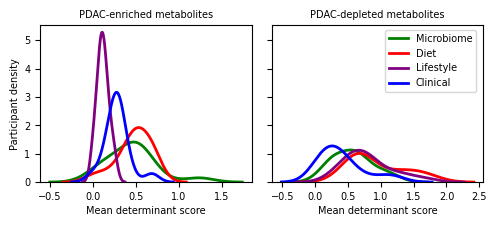

In [64]:
# Visualize kde plots of determinant scores for PDAC-enriched and PDAC-depleted metabolites.

labels_fontsize = 7
tick_fontsize = 7
title_padding = 3
width_in = 130 / 25.4
height_in = 60 / 25.4
colors = ['green', 'red', 'purple', 'blue']
scores = ['microbiome_score', 'diet_score', 'lifestyle_score', 'clinical_score']

fig, axes = plt.subplots(1, 2, figsize=(width_in, height_in), sharey=True)

for score, color in zip(scores, colors):
    sns.kdeplot(enriched_feature_scores[score], label=score.split('_')[0].title(), ax=axes[0], color=color, lw=2)

axes[0].set_title('PDAC-enriched metabolites', fontsize=labels_fontsize, pad=title_padding+2)
axes[0].set_xlabel('Mean determinant score', fontsize=labels_fontsize, labelpad=title_padding)
axes[0].set_ylabel('Participant density', fontsize=labels_fontsize, labelpad=title_padding)
axes[0].tick_params(labelsize=tick_fontsize)

for score, color in zip(scores, colors):
    sns.kdeplot(depleted_feature_scores[score], label=score.split('_')[0].title(), ax=axes[1], color=color, lw=2)

axes[1].set_title('PDAC-depleted metabolites', fontsize=labels_fontsize, pad=title_padding+2)
axes[1].set_xlabel('Mean determinant score', fontsize=labels_fontsize, labelpad=title_padding)
axes[1].tick_params(labelsize=tick_fontsize)

axes[1].legend(fontsize=tick_fontsize, loc='upper left', bbox_to_anchor=(0.511, 1))

plt.tight_layout()
plt.savefig("combined_pdac_metabolites.png", dpi=300, bbox_inches='tight')
plt.show()

Standrdizing the scores based on the features in each patient

In [65]:
standardized_depleted = depleted_feature_scores.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
standardized_enriched = enriched_feature_scores.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

standardized_depleted.columns = [f"{col}_Depleted" for col in standardized_depleted.columns]
standardized_enriched.columns = [f"{col}_Enriched" for col in standardized_enriched.columns]

merged_standardized_df = pd.concat([standardized_depleted, standardized_enriched], axis=1)

Heatmap (Fig. 4f)

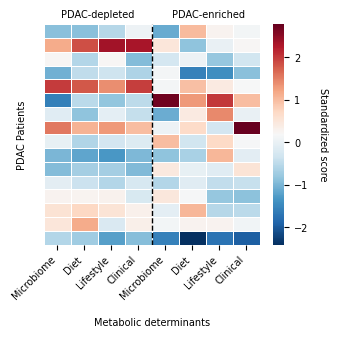

In [66]:
# Visualizing standardized determinant scores for PDAC-enriched and PDAC-depleted metabolites.

merged_standardized_df.columns = [
    'Microbiome', 'Diet', 'Lifestyle', 'Clinical',
    'Microbiome', 'Diet', 'Lifestyle', 'Clinical'
]
plt.figure(figsize=(3.5, 3.5))

ax = sns.heatmap(merged_standardized_df, cmap='RdBu_r', linewidths=0.5, linecolor='white',
                 cbar_kws={'label': 'Standardized score', 'ticks': [-2, -1, 0, 1, 2]},
                 yticklabels=False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, ha='center')

plt.xlabel('Metabolic determinants', fontsize=7, labelpad=12)
plt.ylabel('PDAC Patients', fontsize=7, labelpad=12)

plt.xticks(rotation=45, ha='right')

plt.text(2, -0.5, 'PDAC-depleted', fontsize=7, ha='center')
plt.text(6.1, -0.5, 'PDAC-enriched', fontsize=7, ha='center')

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_rotation(270)
cbar.ax.yaxis.labelpad = 14
cbar.set_label('Standardized score', fontsize=7)
cbar.ax.tick_params(labelsize=7)

plt.axvline(x=4, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.savefig("heat_map.png", dpi=300, bbox_inches='tight')
plt.show()

Radar plot (Fig. 4g)

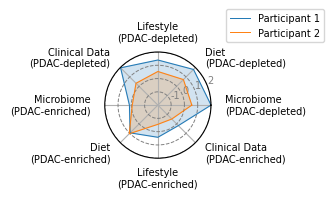

In [72]:
# Comparing metabolic determinant scores for two PDAC patients, 
# showing enriched and depleted categories of all 4 determinants.

# We choose 2 patients with similar covariates.
patients = ['SPC_425', 'SPC_667']  

merged_standardized_df.columns = [
    'Microbiome\n(PDAC-depleted)', 'Diet\n(PDAC-depleted)', 'Lifestyle\n(PDAC-depleted)', 'Clinical Data\n(PDAC-depleted)',
    'Microbiome\n(PDAC-enriched)', 'Diet\n(PDAC-enriched)', 'Lifestyle\n(PDAC-enriched)', 'Clinical Data\n(PDAC-enriched)'
]

categories = [
    'Microbiome\n(PDAC-depleted)', 'Diet\n(PDAC-depleted)', 'Lifestyle\n(PDAC-depleted)', 'Clinical Data\n(PDAC-depleted)',
    'Microbiome\n(PDAC-enriched)', 'Diet\n(PDAC-enriched)', 'Lifestyle\n(PDAC-enriched)', 'Clinical Data\n(PDAC-enriched)'
]
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] 

# Standardized determinant scores for the 2 selected patients.
patient1_values = merged_standardized_df.loc[patients[0], categories].tolist()
patient1_values += patient1_values[:1]

patient2_values = merged_standardized_df.loc[patients[1], categories].tolist()
patient2_values += patient2_values[:1]

fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))

ax.plot(angles, patient1_values, linewidth=0.7, linestyle='solid', label='Participant 1', color='#1f77b4')
ax.fill(angles, patient1_values, color='#1f77b4', alpha=0.2)

ax.plot(angles, patient2_values, linewidth=0.7, linestyle='solid', label='Participant 2', color='#ff7f0e')
ax.fill(angles, patient2_values, color='#ff7f0e', alpha=0.2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=7, ha='center')

tick_values = [-1, 0, 1, 2]  
ax.set_yticks(tick_values)  
ax.set_yticklabels([str(int(tick)) for tick in tick_values], fontsize=7, color='gray') 

ax.set_ylim(-2, 2) 

ax.yaxis.grid(True, linestyle='--', color='gray', linewidth=0.7)

for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if angle_deg == 90 or angle_deg == 270:
        label.set_horizontalalignment('center')
        label.set_position((0, -0.01))  
    if angle_deg < 90 or angle_deg > 270:
        label.set_horizontalalignment('left')
        label.set_position((0.01, 0.1))  
    if 90 < angle_deg < 270:
        label.set_horizontalalignment('right')
        label.set_position((-0.01, 0.1)) 

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.45), fontsize=7)

plt.tight_layout()
plt.savefig("radar_plot.png", dpi=300, bbox_inches='tight')
plt.show()